/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Teste F - Valores F: [18662.44053713]
Teste F - Valores p: [0.]
Teste t - Valores p para cada coeficiente de regressão: {'Regressão Linear': array([0.]), 'Ridge Regression': array([0.]), 'Lasso Regression': array([1.]), 'ElasticNet Regression': array([1.]), 'Support Vector Regression': array([1.])}
Treinando modelo: Regressão Linear
Regressão Linear: MAE = 0.06402128543012282, MSE = 0.010729471903622879, RMSE = 0.1035831641900501, R2 = 0.371046978216528
Treinando modelo: Ridge Regression
Ridge Regression: MAE = 0.0640281641307109, MSE = 0.010729584964381077, RMSE = 0.10358370993733076, R2 = 0.3710403506857276
Treinando modelo: Lasso Regression
Lasso Regression: MAE = 0.09666772547138, MSE = 0.017059285451242235, RMSE = 0.13061119956283318, R2 = -1.60589476361217e-06
Treinando modelo: ElasticNet Regression
ElasticNet Regression: MAE = 0.09666772547138, MSE = 0.017059285451242235, RMSE = 0.13061119956283318, R2 = -1.60589476361217e-06
Treinando modelo: Support Vector Regression
Support V

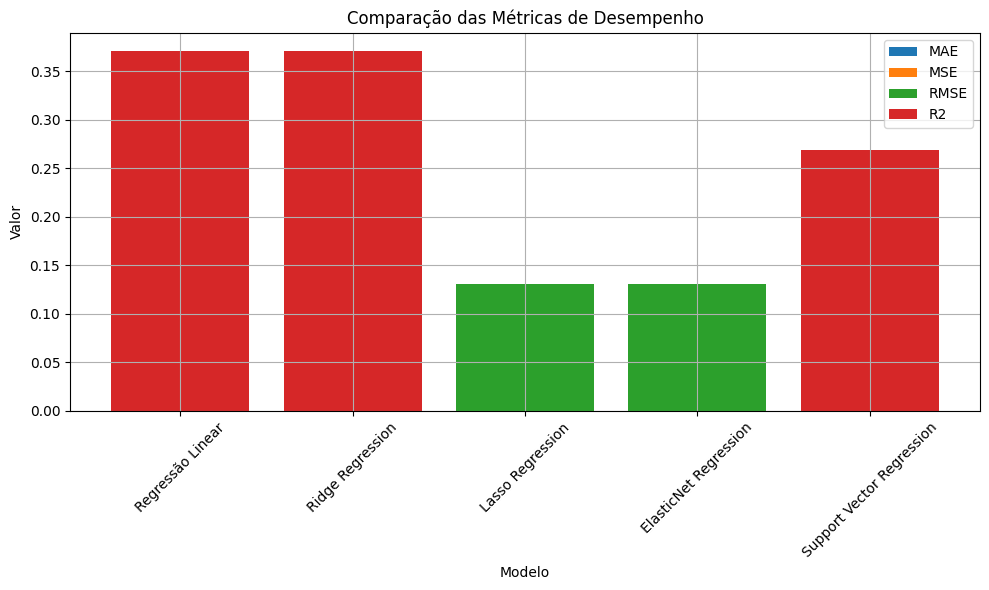


Métricas para cada modelo:
                                MAE       MSE      RMSE        R2
Regressão Linear           0.064021  0.010729  0.103583  0.371047
Ridge Regression           0.064028  0.010730  0.103584  0.371040
Lasso Regression           0.096668  0.017059  0.130611 -0.000002
ElasticNet Regression      0.096668  0.017059  0.130611 -0.000002
Support Vector Regression  0.094468  0.012464  0.111643  0.269363

Melhor desempenho de cada modelo:
MAE     Lasso Regression
MSE     Lasso Regression
RMSE    Lasso Regression
R2      Regressão Linear
dtype: object


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import f_regression
from scipy.stats import t as t_dist
from sklearn.decomposition import PCA

class RegressaoModelos:
    def __init__(self, df):
        self.df = df
        self.modelos = {
            "Regressão Linear": LinearRegression(),
            "Ridge Regression": Ridge(),
            "Lasso Regression": Lasso(),
            "ElasticNet Regression": ElasticNet(),
            "Support Vector Regression": SVR(),
        }

    def pre_processamento(self):
        self.df['c2'].fillna('Unknown', inplace=True)
        self.df['c6'].fillna('Unknown', inplace=True)
        self.df = self.df.drop(columns=['n9'])
        self.df.replace([np.inf, -np.inf], np.nan, inplace=True)
        self.df['n10'] = self.df['n10'].fillna(self.df['n10'].mean())

        def remover_outliers(df, colunas):
            df_limpo = df.copy()
            for coluna in colunas:
                df_col = df_limpo[coluna]
                escore_z = np.abs(stats.zscore(df_col))
                df_limpo = df_limpo[(escore_z < 3)]
            return df_limpo

        colunas_numericas = ['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n10', 'n11', 'n12', 'n13', 'n14']
        self.df = remover_outliers(self.df, colunas_numericas)

        self.X = self.df.drop(['id', 'variant'], axis=1)
        self.y = self.df['n14']

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)

        encoder = OneHotEncoder(sparse=False, drop='first')
        self.X_train_encoded = encoder.fit_transform(self.X_train.select_dtypes(include=['object']))
        self.X_test_encoded = encoder.transform(self.X_test.select_dtypes(include=['object']))

        self.X_train_encoded = pd.concat([pd.DataFrame(self.X_train_encoded, columns=encoder.get_feature_names_out()),
                                          self.X_train.select_dtypes(exclude=['object']).reset_index(drop=True)], axis=1)
        self.X_test_encoded = pd.concat([pd.DataFrame(self.X_test_encoded, columns=encoder.get_feature_names_out()),
                                         self.X_test.select_dtypes(exclude=['object']).reset_index(drop=True)], axis=1)

        pca = PCA(n_components=0.95)
        self.X_train_pca = pca.fit_transform(self.X_train_encoded)
        self.X_test_pca = pca.transform(self.X_test_encoded)

        self.scaler = MinMaxScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train_pca)
        self.X_test_scaled = self.scaler.transform(self.X_test_pca)

    def testes_significancia(self):
      f_values, p_values = f_regression(self.X_train_scaled, self.y_train)

      resultados_p_values_t = {}
      for nome, modelo in self.modelos.items():
          modelo.fit(self.X_train_scaled, self.y_train)
          if hasattr(modelo, 'coef_'):
              coeficientes = modelo.coef_
          else:
              coeficientes = np.zeros(self.X_train_scaled.shape[1])
          p_values_t = self.calcular_p_values(self.X_train_scaled, self.y_train, coeficientes)
          resultados_p_values_t[nome] = p_values_t

      return f_values, p_values, resultados_p_values_t

    def calcular_p_values(self, X, y, coefficients):
        n_obs = len(y)
        n_features = X.shape[1]
        df_residual = n_obs - n_features
        df_total = n_obs - 1
        sse = np.sum((y - np.dot(X, coefficients)) ** 2)
        var_residual = sse / df_residual
        XtX_inv_diag = np.diagonal(np.linalg.inv(np.dot(X.T, X)))
        se = np.sqrt(var_residual * XtX_inv_diag)
        t_values = coefficients / se
        p_values_t = 2 * (1 - t_dist.cdf(np.abs(t_values), df_residual))
        return p_values_t

    def treinar_modelos(self):
        resultados = {}
        for nome, modelo in self.modelos.items():
            print(f"Treinando modelo: {nome}")
            modelo.fit(self.X_train_scaled, self.y_train)
            y_pred = modelo.predict(self.X_test_scaled)
            mae = mean_absolute_error(self.y_test, y_pred)
            mse = mean_squared_error(self.y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(self.y_test, y_pred)
            resultados[nome] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}
            print(f"{nome}: MAE = {mae}, MSE = {mse}, RMSE = {rmse}, R2 = {r2}")
        return resultados

    def verificar_multicolinearidade(self):
        matriz_cov = np.cov(self.X_train_scaled, rowvar=False)
        if matriz_cov.ndim == 0:
            matriz_cov = np.atleast_2d(matriz_cov)
        cond_number = np.linalg.cond(matriz_cov)
        return cond_number

    def organizar_metricas(self, resultados):
        metricas_df = pd.DataFrame(resultados).T
        return metricas_df

    def plotar_metricas(self, resultados):
        fig, ax = plt.subplots(figsize=(10, 6))
        metricas = ['MAE', 'MSE', 'RMSE', 'R2']
        for metrica in metricas:
            valores = [resultados[m][metrica] for m in resultados]
            ax.bar(resultados.keys(), valores, label=metrica)

        ax.set_xlabel('Modelo')
        ax.set_ylabel('Valor')
        ax.set_title('Comparação das Métricas de Desempenho')
        ax.legend()
        ax.grid(True)
        ax.set_xticks(range(len(resultados)))
        ax.set_xticklabels(resultados.keys(), rotation=45)

        plt.tight_layout()
        plt.show()

    def melhor_desempenho(self, metricas_df, metrica='R2'):
      melhor_desempenho = metricas_df.idxmax() if metrica != 'RMSE' else metricas_df.idxmin()
      return melhor_desempenho

df = pd.read_csv("/content/hotmart_ml_test.csv")

modelo = RegressaoModelos(df)
modelo.pre_processamento()

f_values, p_values_f, p_values_t = modelo.testes_significancia()
print("Teste F - Valores F:", f_values)
print("Teste F - Valores p:", p_values_f)
print("Teste t - Valores p para cada coeficiente de regressão:", p_values_t)

resultados = modelo.treinar_modelos()

cond_number = modelo.verificar_multicolinearidade()
print(f"Condition Number: {cond_number}")

modelo.plotar_metricas(resultados)

metricas_df = modelo.organizar_metricas(resultados)
print("\nMétricas para cada modelo:")
print(metricas_df)

melhor_desempenho = modelo.melhor_desempenho(metricas_df)
print("\nMelhor desempenho de cada modelo:")
print(melhor_desempenho)
